## Load packages

In [1]:
import sys
sys.path.append("../../")
from ise.visualization import Plotter
from ise.models.testing.pretrained import binned_sle_table
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator
from ise.utils.data import (
    create_distribution,
    kl_divergence,
    js_divergence
)
from itertools import product
import random
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

/users/pvankatw/anaconda/emulator/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data and set MPL params

In [2]:
save_figures = False
dataset = pd.read_csv(r"nn_results.csv")
gp_data = pd.read_csv(r"gp_results.csv")

In [3]:
preds = gp_data['preds']
std = gp_data['std']
dataset['gp_pred'] = preds
dataset['gp_std'] = std
dataset['gp_mse'] = abs(dataset.gp_pred - dataset.true)**2
dataset['gp_mae'] = abs(dataset.gp_pred - dataset.true)

In [4]:
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.size'] = 15
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['figure.figsize'] = 7.2,4.45
# mpl.rcParams['axes.titlesize '] = 16
# mpl.rcParams['axes.labelsize '] = 17
# mpl.rcParams['lines.linewidth '] = 2
# mpl.rcParams['lines.markersize '] = 6
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

true_color = '#66c2a5'
nn_color = '#fc8d62'
gp_color = '#8da0cb'

In [5]:
# plt.style.use('plot_style.txt')

## Format data by grouping by 85-year projection

In [6]:
def group_by_run(dataset: pd.DataFrame, column: str=None, condition: str=None,):
    """Groups the dataset into each individual simulation series by both the true value of the 
    simulated SLE as well as the model predicted SLE. The resulting arrays are NXM matrices with
    N being the number of simulations and M being 85, or the length of the series.

    Args:
        dataset (pd.DataFrame): Dataset to be grouped
        column (str, optional): Column to subset on. Defaults to None.
        condition (str, optional): Condition to subset with. Can be int, str, float, etc. Defaults to None.
        
    Returns:
        tuple: Tuple containing [all_trues, all_preds], or NXM matrices of each series corresponding to true values and predicted values.
    """

    modelnames = dataset.modelname.unique()
    exp_ids = dataset.exp_id.unique()
    sectors = dataset.sectors.unique()

    all_runs = [list(i) for i in list(product(modelnames, exp_ids, sectors))]

    all_trues = []
    all_preds = []
    scenarios = []
    all_gp = []
    all_std = []
    for i, run in enumerate(all_runs):
        modelname = run[0]
        exp = run[1]
        sector = run[2]
        if column is None and condition is None:
            subset = dataset[(dataset.modelname == modelname) & (dataset.exp_id == exp) & (dataset.sectors == sector)]
        elif column is not None and condition is not None:
            subset = dataset[(dataset.modelname == modelname) & (dataset.exp_id == exp) & (dataset.sectors == sector) & (dataset[column] == condition)]
        else:
            raise ValueError('Column and condition type must be the same (None & None, not None & not None).')
        if not subset.empty:
            scenarios.append([modelname, exp, sector])
            all_trues.append(subset.true.to_numpy())
            all_preds.append(subset.pred.to_numpy())
            all_gp.append(subset.gp_pred.to_numpy())
            all_std.append(subset.gp_pred.to_numpy())
            
            
    return np.array(all_trues), np.array(all_preds), scenarios, np.array(all_gp), np.array(all_std)

def get_uncertainty_bands(data: pd.DataFrame, confidence: str='95', quantiles: list[float]=[0.05, 0.95]):
    """Calculates uncertainty bands on the monte carlo dropout protocol. Includes traditional 
    confidence interval calculation as well as a quantile-based approach.

    Args:
        data (pd.DataFrame): Dataframe or array of NXM, typically from ise.utils.data.group_by_run.
        confidence (str, optional): Confidence level, must be in [95, 99]. Defaults to '95'.
        quantiles (list[float], optional): Quantiles of uncertainty bands. Defaults to [0.05, 0.95].

    Returns:
        tuple: Tuple containing [mean, sd, upper_ci, lower_ci, upper_q, lower_q], or the mean prediction, standard deviation, and the lower and upper confidence interval and quantile bands.
    """
    z = {'95': 1.96, '99': 2.58}
    data = np.array(data)
    mean = data.mean(axis=0)
    sd = np.sqrt(data.var(axis=0))
    upper_ci = mean + (z[confidence] * (sd/np.sqrt(data.shape[0])))
    lower_ci = mean - (z[confidence] * (sd/np.sqrt(data.shape[0])))
    quantiles = np.quantile(data, quantiles, axis=0)
    upper_q = quantiles[1,:]
    lower_q = quantiles[0,:]
    return mean, sd, upper_ci, lower_ci, upper_q, lower_q

In [7]:
all_trues, all_preds, scenarios, all_gp, all_std = group_by_run(dataset)

mean_true, true_sd, true_upper_ci, true_lower_ci, true_upper_q, true_lower_q = get_uncertainty_bands(all_trues,)
mean_pred, pred_sd, pred_upper_ci, pred_lower_ci, pred_upper_q, pred_lower_q = get_uncertainty_bands(all_preds,)
mean_gp, gp_sd, gp_upper_ci, gp_lower_ci, gp_upper_q, gp_lower_q = get_uncertainty_bands(all_gp,)


true_df = pd.DataFrame(all_trues).transpose()
pred_df = pd.DataFrame(all_preds).transpose()
gp_df = pd.DataFrame(all_gp).transpose()
std_df = pd.DataFrame(all_std).transpose()


In [8]:
# create 3 year rolling average for GP
rolled_gp = gp_df.rolling(3).mean()
rolled_gp.loc[0, :] = gp_df.loc[0, :]
rolled_gp.loc[1, :] = gp_df.loc[1, :]

In [9]:
# window = 3
# rolled = np.array(pd.DataFrame(mean_gp).rolling(window).mean())
# for i in range(window):
#     rolled[i] = mean_gp[i]


## Ensemble Comparison

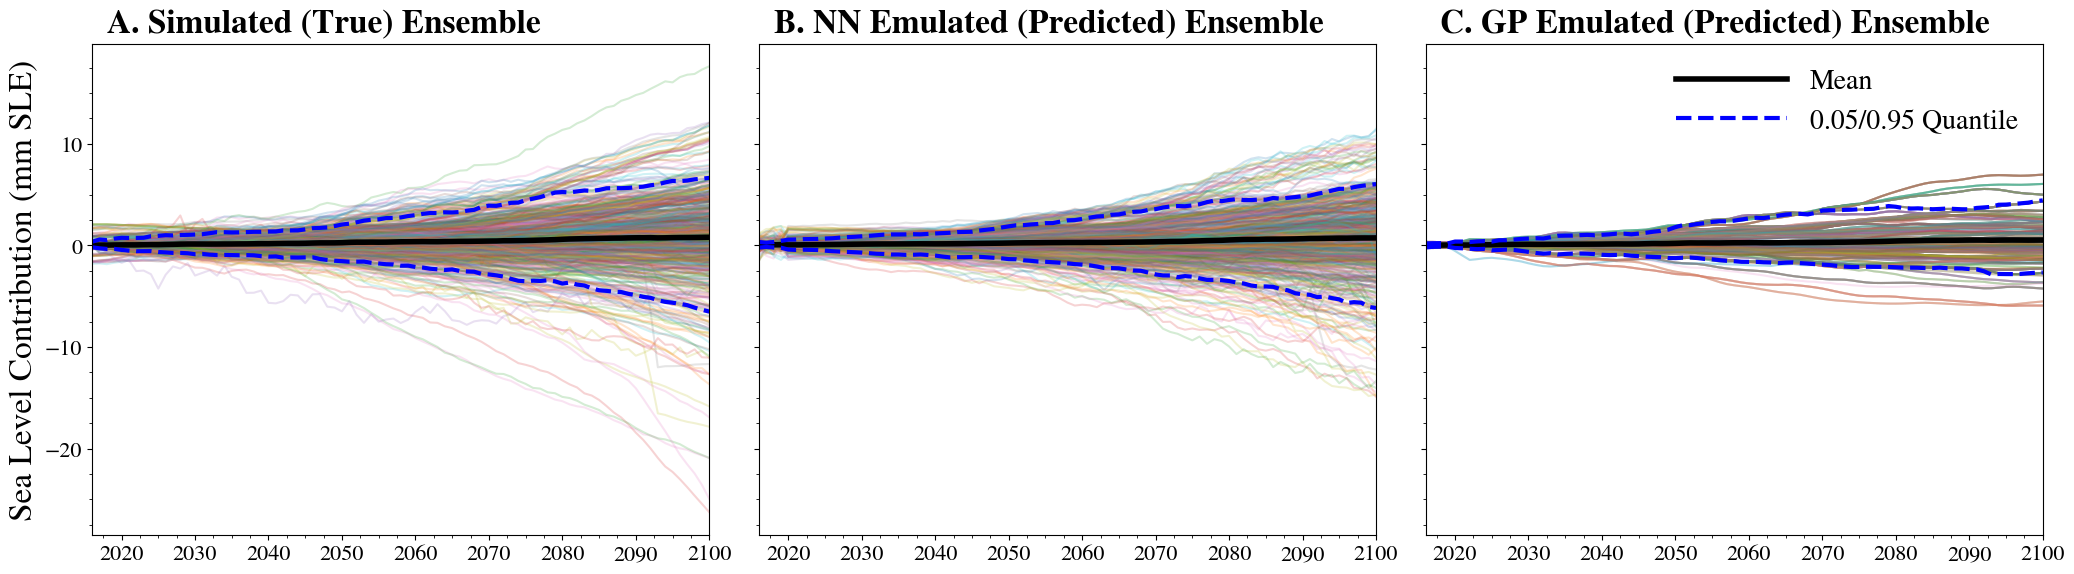

In [10]:
support = np.arange(2016, 2101)
fig, axs = plt.subplots(1, 3, figsize=(21, 6), sharey=True, sharex=True)
axs[0].plot(support, true_df, 
#             color='gray', 
            alpha=0.2)
axs[0].plot(support, mean_true, 
            "k-", 
            linewidth=4, 
            label="Mean")
axs[1].plot(support, pred_df, 
#             color='gray', 
            alpha=0.2)
axs[1].plot(support, mean_pred, 
            "k-", 
            linewidth=4, 
            label="Mean")
axs[2].plot(support, 
#             gp_df,
            rolled_gp, 
#             color='gray', 
            alpha=0.2)
axs[2].plot(support, mean_gp, 
            "k-", 
            linewidth=4, 
            label="Mean")

axs[1].plot(support, pred_upper_q, "b--", linewidth=3, label="5/95% Percentile (Predicted)")
axs[1].plot(support, pred_lower_q, "b--", linewidth=3)
axs[0].plot(support, true_upper_q, "b--", linewidth=3, label="0.05/0.95 Quantile")
axs[0].plot(support, true_lower_q, "b--", linewidth=3)
axs[2].plot(support, gp_upper_q, "b--", linewidth=3, label="0.05/0.95 Quantile")
axs[2].plot(support, gp_lower_q, "b--", linewidth=3)

# axs[0].title.set_text("True")
axs[0].set_ylabel('Sea Level Contribution (mm SLE)', {'fontsize': 24})
# axs[1].title.set_text("Predicted")
axs[0].text(2018, 21, 'A. Simulated (True) Ensemble', {'fontsize': 24, 'weight': 550})
axs[1].text(2018, 21, 'B. NN Emulated (Predicted) Ensemble', {'fontsize': 24, 'weight': 550})
axs[2].text(2018, 21, 'C. GP Emulated (Predicted) Ensemble', {'fontsize': 24, 'weight': 550})
# axs[0].text(2090, 24, 'Comparison of Simulated (True) vs Emulated (Predicted) Ensemble')
# axs[1].text(1997, 24, 'Comparison of Simulated (True) vs Emulated (Predicted) Ensemble')
# plt.xlabel("Years since 2015")
# plt.suptitle(f"Comparison of Simulated (True) vs Emulated (Predicted) Ensemble")
# plt.subplots_adjust(wspace=0, hspace=0)

# plt.legend()
# plt.tight_layout()


axs[0].yaxis.set_major_formatter(ScalarFormatter())
axs[0].yaxis.set_minor_locator(AutoMinorLocator(4))
axs[0].xaxis.set_minor_locator(AutoMinorLocator(4))
axs[2].legend(frameon=False, loc='upper right',ncol=1,handlelength=4, fontsize=20)
axs[0].set_xlim([2016, 2100])

plt.tight_layout()

if save_figures:
    plt.savefig('ensemble_with_gp.png', dpi=800)
plt.show()

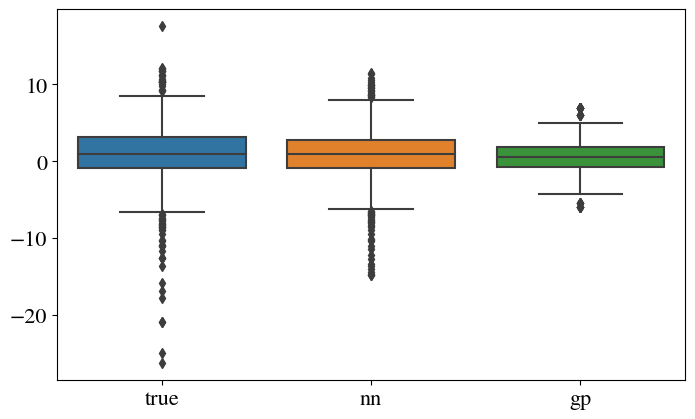

In [11]:
year2100 = pd.DataFrame(dict(true=true_df.iloc[84], nn=pred_df.iloc[84], gp=rolled_gp.iloc[84]))
sns.boxplot(year2100)
if save_figures:
    plt.savefig('boxplots.svg')

## Mean and Distribution Comparison

In [12]:
sector_year = pd.DataFrame(dataset.groupby(by=['sectors', 'year']).mean())
summed = sector_year.groupby(by='year').sum()

rolled_gp = summed['gp_pred'].rolling(3).mean()
rolled_gp[:3] = summed['gp_pred'][:3]

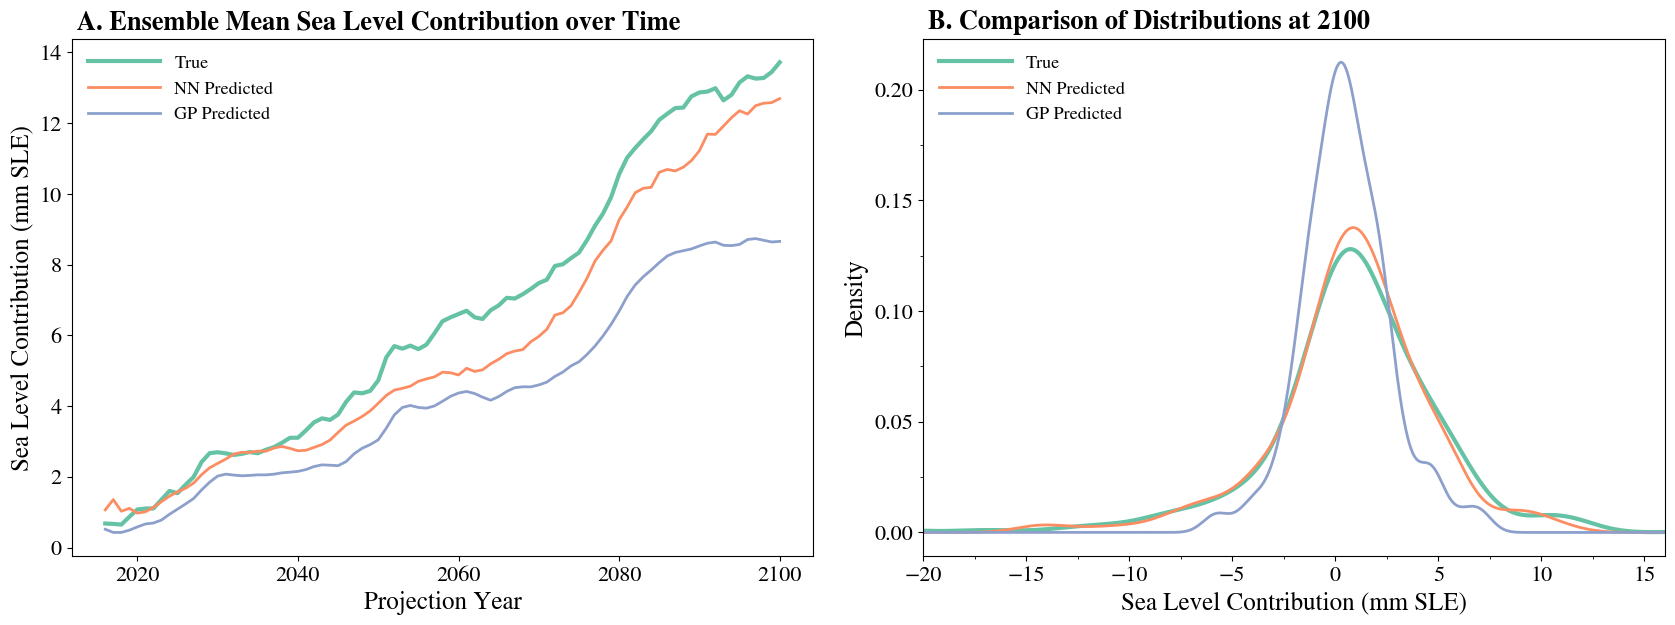

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(17, 6.5), sharey=False, sharex=False)

axs[0].plot(np.arange(2016, 2101), summed['true'], label='True', color=true_color, linewidth=3)
axs[0].plot(np.arange(2016, 2101), summed['pred'], label='NN Predicted', color=nn_color, linewidth=2)
# plt.plot(np.arange(2016, 2101), mean_gp, label='GP Predicted', color=gp_color)
axs[0].plot(np.arange(2016, 2101), rolled_gp, label='GP Predicted', color=gp_color, linewidth=2)
# axs[0].title('Ensemble Mean Sea Level Contribution over Time', {'fontsize': 'medium', 'weight': 650}, loc='right')
axs[0].set_ylabel('Sea Level Contribution (mm SLE)', {'fontsize': 18})

year = 2100
true_dist, true_support = create_distribution(year=year, dataset=all_trues)
pred_dist, pred_support = create_distribution(year=year, dataset=all_preds)
gp_dist, gp_support = create_distribution(year=year, dataset=all_gp)

axs[1].plot(true_support, true_dist, label="True", color=true_color, linewidth=3)
axs[1].plot(true_support, pred_dist, label="NN Predicted", color=nn_color, linewidth=2)
axs[1].plot(pred_support, gp_dist, label="GP Predicted", color=gp_color, linewidth=2)
# ax.title(
#     f"Distribution Comparison at year {year}, KL Divergence: {kl_divergence(pred_dist, true_dist):0.3f}"
# )

axs[1].yaxis.set_major_formatter(ScalarFormatter())
axs[1].yaxis.set_minor_locator(  AutoMinorLocator(2))
axs[1].xaxis.set_minor_locator(  AutoMinorLocator(2))

# ax.text(-31, .41, f"NN KLD: {kl_divergence(pred_dist, true_dist):0.3f}")
# ax.text(-31, .41 - (.41-.38), f"GP KLD: {kl_divergence(gp_dist, true_dist):0.3f}")

axs[0].text(2012.5, 14.65, 'A. Ensemble Mean Sea Level Contribution over Time', {'fontsize': 19, 'weight': 550})
axs[1].text(-19.75, 0.2275, 'B. Comparison of Distributions at 2100', {'fontsize': 19, 'weight': 550})
# axs[0].text(2016.5, 15.5, title1, {'fontsize': 18, 'weight': 550})

axs[1].set_xlabel("Sea Level Contribution (mm SLE)", {'fontsize': 18})
axs[0].set_xlabel("Projection Year", {'fontsize': 18})
axs[1].set_ylabel("Density", {'fontsize': 18})
axs[1].legend(frameon=False, loc='upper left',ncol=1,handlelength=4)
axs[0].legend(frameon=False, loc='upper left',ncol=1,handlelength=4)
axs[1].set_xlim([-20, 16])

if save_figures:
    plt.savefig('mean-dist.png',)

plt.show()

## Error by Projection Year

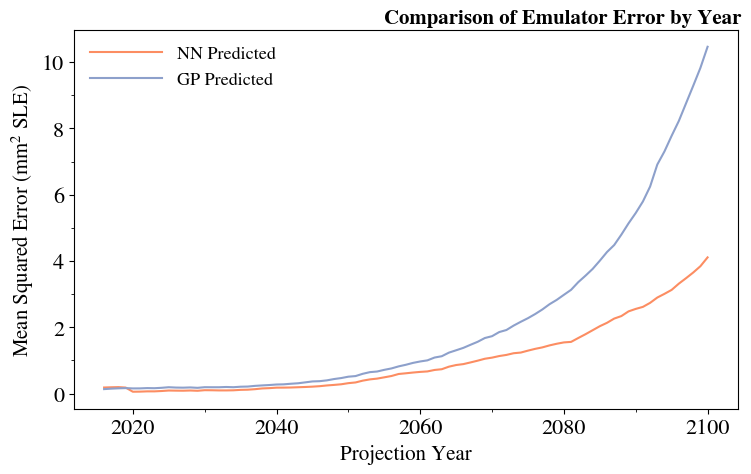

In [14]:
by_year = dataset.groupby('year').mean()[['mse','gp_mse']]
years = by_year.index
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(years, by_year['mse'], label="NN Predicted", color=nn_color)
ax.plot(years, by_year['gp_mse'], label="GP Predicted", color=gp_color)

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_locator(  AutoMinorLocator(2))
ax.xaxis.set_minor_locator(  AutoMinorLocator(2))
ax.text(2055, 11.18, f'Comparison of Emulator Error by Year', {'weight': 700})

# ax.text(-19, .205, f"NN KLD: {kl_divergence(pred_dist, true_dist):0.3f}")
# ax.text(-19, .19, f"GP KLD: {kl_divergence(gp_dist, true_dist):0.3f}")

ax.set_xlabel("Projection Year")
ax.set_ylabel("Mean Squared Error (mm$^2$ SLE)")
ax.legend(frameon=False, loc='upper left',ncol=1,handlelength=4)
# ax.set_xlim([-20, 20])

if save_figures:
    plt.savefig('error_by_year.png', dpi=800)

plt.show()

## KL Divergence by Projection Year

In [15]:
gp_metrics = []
nn_metrics = []
for year in range(2016, 2101):
    true_dist, true_support = create_distribution(year=year, dataset=all_trues)
    pred_dist, pred_support = create_distribution(year=year, dataset=all_preds)
    gp_dist, gp_support = create_distribution(year=year, dataset=all_gp)
    gp_metrics.append([kl_divergence(gp_dist, true_dist), js_divergence(gp_dist, true_dist)])
    nn_metrics.append([kl_divergence(pred_dist, true_dist), js_divergence(pred_dist, true_dist)])

gp_metrics = np.array(gp_metrics)
nn_metrics = np.array(nn_metrics)

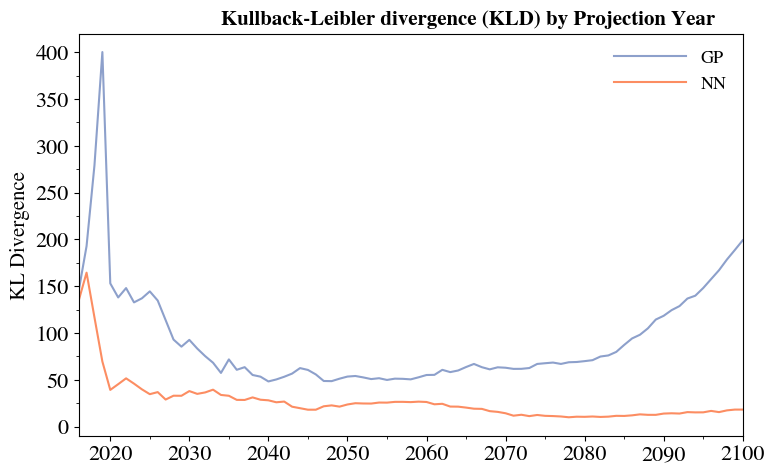

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(np.arange(2016, 2101), gp_metrics[:, 0], label='GP', color=gp_color)
ax.plot(np.arange(2016, 2101,), nn_metrics[:, 0], label='NN', color=nn_color)

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_locator(  AutoMinorLocator(2))
ax.xaxis.set_minor_locator(  AutoMinorLocator(2))
ax.text(2034, 430, f'Kullback-Leibler divergence (KLD) by Projection Year', {'weight': 700})

# ax.text(-31, .41, f"NN KLD: {kl_divergence(pred_dist, true_dist):0.3f}")
# ax.text(-31, .41 - (.41-.38), f"GP KLD: {kl_divergence(gp_dist, true_dist):0.3f}")

ax.set_ylabel("KL Divergence")
ax.legend(frameon=False, loc='upper right',ncol=1,handlelength=4)
ax.set_xlim([2016, 2100])

if save_figures:
    plt.savefig('kld.png', dpi=800)

plt.show()

## Results Tables

In [17]:
nn_time_sec = 708.282
gp_time_sec = 7111.943440437317
table = {
    "Neural Network": [dataset.mse.mean(), dataset.mae.mean(), r2_score(dataset.true, dataset.pred), nn_time_sec/60, kl_divergence(pred_dist, true_dist), js_divergence(pred_dist, true_dist)],
    "Gaussian Process": [dataset.gp_mse.mean(), dataset.gp_mae.mean(), r2_score(dataset.true, dataset.gp_pred), gp_time_sec/60, kl_divergence(gp_dist, true_dist), js_divergence(gp_dist, true_dist)],
    
}
table = pd.DataFrame(table)
table.index = ['Mean Squared Error', 'Mean Absolute Error', 'R^2', 'Time to train (min)', 'KL Divergence at 2100', 'JS Divergence at 2100']
table

,Neural Network,Gaussian Process
Mean Squared Error,1.011355,2.070138
Mean Absolute Error,0.461902,0.733196
R^2,0.777241,0.544035
Time to train (min),11.804700,118.532391
KL Divergence at 2100,18.132596,199.137813
JS Divergence at 2100,0.073723,0.241297


In [18]:
def binned_sle_table(
    results_dataframe: pd.DataFrame,
    bins,
):
    """Creates table that analyzes loss functions over given ranges of SLE. Input is the results
    dataframe from ise.utils.data.combine_testing_results. Note that bins can be an integer denoting
    how many equal-width bins you want to cut the data into, or it can be a list of cutoffs. If the list does not
    contain the mins and maxes of SLE in the dataset, it will be added automatically.
    Args:
        results_dataframe (pd.DataFrame): Testing results dataframe outputted from ise.utils.data.combine_testing_results
        bins (list, optional): List of bin cutoffs or integer number of equal-width bins. Defaults to None.
    Returns:
        pd.DataFrame: Table of metrics per binned SLE.
    """
    if not bins:
        bins = 5

    if not isinstance(bins, list) and not isinstance(bins, int):
        raise AttributeError(
            f"bins type must be list[numeric] or int, received {type(bins)}"
        )

    if isinstance(bins, list):
        min_sle, max_sle = min(results_dataframe.true), max(results_dataframe.true)
        if bins[0] != min_sle:
            bins.insert(0, min_sle)
        if bins[-1] != max_sle:
            bins.append(max_sle)

    results_dataframe["sle_bin"], groups = pd.cut(
        results_dataframe.true, bins, labels=None, retbins=True, include_lowest=True
    )
    mse_by_group = results_dataframe.groupby("sle_bin").mean()[["mse", "mae"]]
    mse_by_group["Count"] = results_dataframe.groupby("sle_bin").count()["true"]
    mse_by_group["Prop"] = (mse_by_group["Count"] / len(results_dataframe)) * 100
    mse_by_group["Prop"] = round(mse_by_group["Prop"], 4).astype(str) + "%"
    mse_by_group.index = [
        f"Between {val:0.2f} and {groups[i+1]:0.2f} mm SLE"
        for i, val in enumerate(groups[:-1])
    ]
    mse_by_group.columns = [
        "Mean Squared Error",
        "Mean Absolute Error",
        "Count in Test Dataset",
        "Proportion in Test Dataset",
    ]

    return pd.DataFrame(mse_by_group)

In [19]:
binned_sle_table(dataset, bins=[-15, -8, 0, 8, 15])

,Mean Squared Error,Mean Absolute Error,Count in Test Dataset,Proportion in Test Dataset
Between -26.27 and -15.00 mm SLE,54.414084,6.944358,84,0.133%
Between -15.00 and -8.00 mm SLE,18.439293,3.632665,292,0.4624%
Between -8.00 and 0.00 mm SLE,0.987987,0.522783,23594,37.3589%
Between 0.00 and 8.00 mm SLE,0.719934,0.376127,38846,61.509%
Between 8.00 and 15.00 mm SLE,5.820326,1.509610,329,0.5209%
Between 15.00 and 17.63 mm SLE,72.507691,8.507467,10,0.0158%


## Example Projection

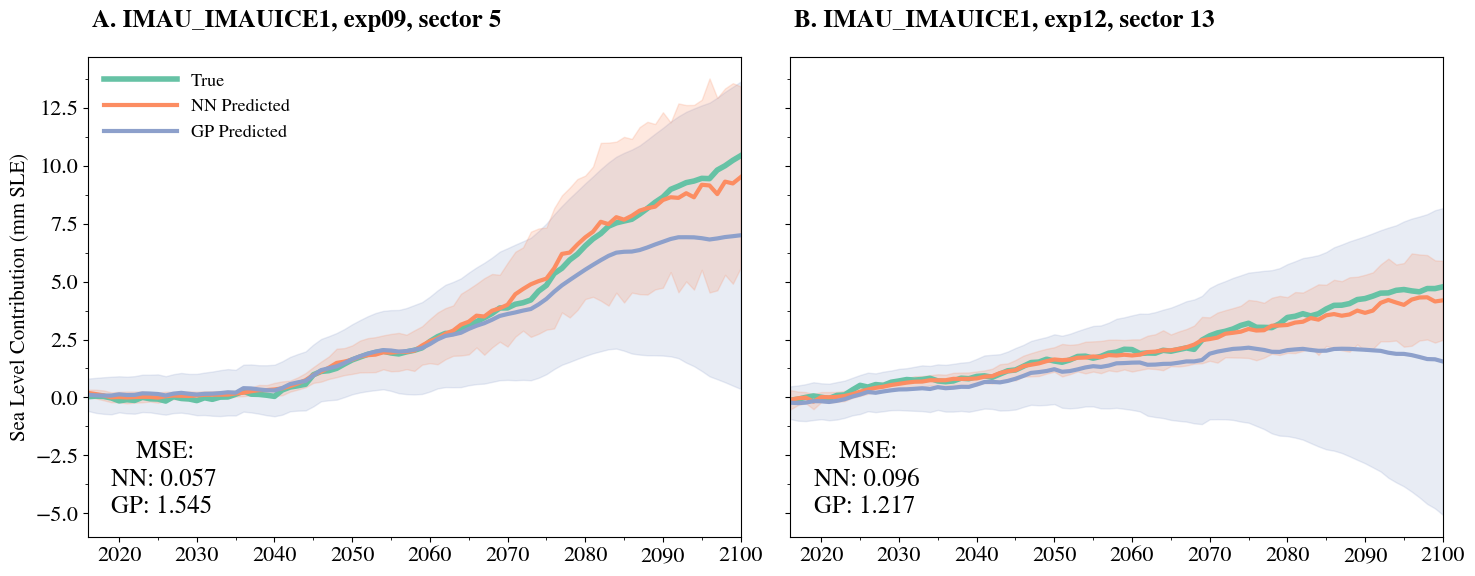

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True, sharex=True)

chunk = dataset[(dataset.modelname == "IMAU_IMAUICE1") & (dataset.exp_id == 'exp09') & (dataset.sectors == 0.2352941176470588)]
chunkb = dataset[(dataset.modelname == "IMAU_IMAUICE1") & (dataset.exp_id == 'exp12') & (dataset.sectors == 0.7058823529411764)]
# chunk = dataset[(dataset.modelname == "PIK_PISM1") & (dataset.exp_id == 'exp04') & (round(dataset.sectors, 8) == 0.17647059)]
# chunkb = dataset[(dataset.modelname == "PIK_PISM1") & (dataset.exp_id == 'exp01') & (dataset.sectors == 0.7058823529411764)]



axs[1].plot(chunk.year, chunk.true, label='True', color=true_color, linewidth=4)
axs[1].plot(chunk.year, chunk.pred, label='NN Predicted', color=nn_color, linewidth=3)
axs[1].plot(chunk.year, chunk.gp_pred, label='GP Predicted', color=gp_color, linewidth=3)
axs[1].fill_between(
    chunk.year,
    chunk.gp_pred - 1.96 * chunk.gp_std,
    chunk.gp_pred + 1.96 * chunk.gp_std,
    alpha=0.2,
    color=gp_color,
)
axs[1].fill_between(
    chunk.year,
    chunk.lower_bound,
    chunk.upper_bound,
    alpha=0.2,
    color=nn_color,
)

axs[0].plot(chunkb.year, chunkb.true, label='True', color=true_color, linewidth=4)
axs[0].plot(chunkb.year, chunkb.pred, label='NN Predicted', color=nn_color, linewidth=3)
axs[0].plot(chunkb.year, chunkb.gp_pred, label='GP Predicted', color=gp_color, linewidth=3)
axs[0].fill_between(
    chunkb.year,
    chunkb.gp_pred - 1.96 * chunkb.gp_std,
    chunkb.gp_pred + 1.96 * chunkb.gp_std,
    alpha=0.2,
    color=gp_color,
)
axs[0].fill_between(
    chunkb.year,
    chunkb.lower_bound,
    chunkb.upper_bound,
    alpha=0.2,
    color=nn_color,
)
title = chunk.iloc[0]
title1 = f"A. {title.modelname}, {title.exp_id}, sector 5"
title0 = f"B. {title.modelname}, exp12, sector 13"

axs[0].yaxis.set_major_formatter(ScalarFormatter())
axs[0].yaxis.set_minor_locator(  AutoMinorLocator(2))
axs[0].xaxis.set_minor_locator(  AutoMinorLocator(2))
axs[1].text(2016.5, 16, title0, {'fontsize': 18, 'weight': 550})
axs[0].text(2016.5, 16, title1, {'fontsize': 18, 'weight': 550})
first_metrics = f"""    MSE:
NN: {chunk.mse.mean():0.3f}
GP: {chunk.gp_mse.mean():0.3f}"""
second_metrics = f"""    MSE:
NN: {chunkb.mse.mean():0.3f}
GP: {chunkb.gp_mse.mean():0.3f}"""
axs[0].text(2019, -5, first_metrics, {'fontsize': 18, 'weight': 200})
axs[1].text(2019, -5, second_metrics, {'fontsize': 18, 'weight': 200})


axs[0].set_ylabel("Sea Level Contribution (mm SLE)")
# ax.set_ylabel("Density")
axs[0].set_xlim([2016, 2100])
axs[0].legend(frameon=False, loc='upper left',ncol=1,handlelength=4)
if save_figures:
    plt.savefig('example_proj_0.4.svg')
plt.show()

# IMAU_IMAUICE1, exp09, 0.2352941176470588
# IMAU_IMAUICE1, exp12, 0.7058823529411764    

## Calibrated Uncertainty Interval Widths

In [21]:
def calibration(scale, calibration, pred, sd, true,):
    scaled_upper = pred + scale*sd
    scaled_lower = pred - scale*sd
    in_bounds = (true >= scaled_lower) & (true <= scaled_upper)
    return np.mean(in_bounds) - calibration

In [22]:
dataset['in_bounds'] = (dataset.true >= dataset.lower_bound) & (dataset.true <= dataset.upper_bound)

from scipy.optimize import fsolve
certainty = 0.95
nn_scale = fsolve(calibration, x0=6, args=(certainty, dataset.pred, dataset.sd, dataset.true))
gp_scale = fsolve(calibration, x0=2, args=(certainty, dataset.gp_pred, dataset.gp_std, dataset.true))
print(f"""NN Scale: {nn_scale}
GP Scale: {gp_scale}""")

scale = nn_scale[0]
dataset['scaled_upper'] = dataset.pred + scale*dataset.sd
dataset['scaled_lower'] = dataset.pred - scale*dataset.sd
dataset['in_scaled_bounds'] = (dataset.true >= dataset.scaled_lower) & (dataset.true <= dataset.scaled_upper)
print(f"NN Calibration: {np.mean(dataset.in_scaled_bounds)}")

scale = gp_scale[0]
dataset['gp_upper'] = dataset.gp_pred + scale * dataset.gp_std
dataset['gp_lower'] = dataset.gp_pred - scale * dataset.gp_std
dataset['gp_in_bounds'] = (dataset.true >= dataset.gp_lower) & (dataset.true <= dataset.gp_upper)
print(f"GP Calibration: {np.mean(dataset.gp_in_bounds)}")

NN Scale: [6.5177162]
GP Scale: [2.01962303]
NN Calibration: 0.9500118755442958
GP Calibration: 0.9499960414852348


In [23]:
year = 2100
nn, gp = [], []
support = np.arange(0.5, 1, 0.01)
support = [.5, .55, .6, .65, .7, .75, .8, .85, .9, .95,]
for i in support:
    nn_scale = fsolve(calibration, x0=6, args=(i, dataset.pred, dataset.sd, dataset.true))
    gp_scale = fsolve(calibration, x0=2, args=(i, dataset.gp_pred, dataset.gp_std, dataset.true))
    
    scale = nn_scale[0]
    dataset['scaled_upper'] = dataset.pred + scale*dataset.sd
    dataset['scaled_lower'] = dataset.pred - scale*dataset.sd
    dataset['in_scaled_bounds'] = (dataset.true >= dataset.scaled_lower) & (dataset.true <= dataset.scaled_upper)

    scale = gp_scale[0]
    dataset['gp_upper'] = dataset.gp_pred + scale * dataset.gp_std
    dataset['gp_lower'] = dataset.gp_pred - scale * dataset.gp_std
    dataset['gp_in_bounds'] = (dataset.true >= dataset.gp_lower) & (dataset.true <= dataset.gp_upper)
    
    data = dataset[dataset.year == year].copy()
    bound_width = data.scaled_upper - data.scaled_lower
    gp_bound_width = data.gp_upper - data.gp_lower
    nn.append(bound_width.mean())
    gp.append(gp_bound_width.mean())

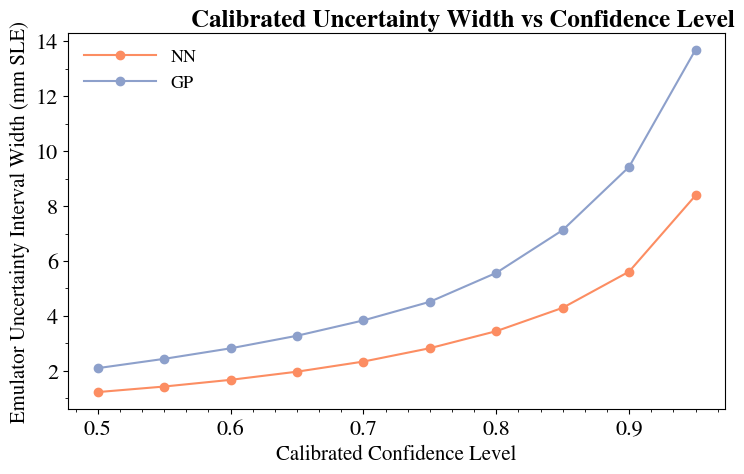

In [24]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(support, nn, label='NN', color=nn_color, marker='o')
ax.plot(support, gp, label='GP', color=gp_color, marker='o')

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_locator(  AutoMinorLocator(2))
ax.xaxis.set_minor_locator(  AutoMinorLocator(6))
ax.text(0.570, 14.55, "Calibrated Uncertainty Width vs Confidence Level", {'fontsize': 18, 'weight': 550})


ax.set_ylabel("Emulator Uncertainty Interval Width (mm SLE)")
ax.set_xlabel("Calibrated Confidence Level")
ax.legend(frameon=False, loc='upper left',ncol=1,handlelength=4)
if save_figures:
    plt.savefig('uncertainty_width.png', dpi=800)
plt.show()

In [25]:
bound_width = dataset.scaled_upper - dataset.scaled_lower
gp_bound_width = dataset.gp_upper - dataset.gp_lower
print(f"Average NN Bound Width: {bound_width.mean()}")
print(f"Average GP Bound Width: {gp_bound_width.mean()}")

year = 2100
data = dataset[dataset.year == year].copy()
bound_width = data.scaled_upper - data.scaled_lower
gp_bound_width = data.gp_upper - data.gp_lower
print(f"Average NN Bound Width at {year}: {bound_width.mean()}")
print(f"Average GP Bound Width at {year}: {gp_bound_width.mean()}")

Average NN Bound Width: 3.6254017062744355
Average GP Bound Width: 5.189005659688467
Average NN Bound Width at 2100: 8.384885961590896
Average GP Bound Width at 2100: 13.69041641318366


## Mean Emulated vs Simulated SLE

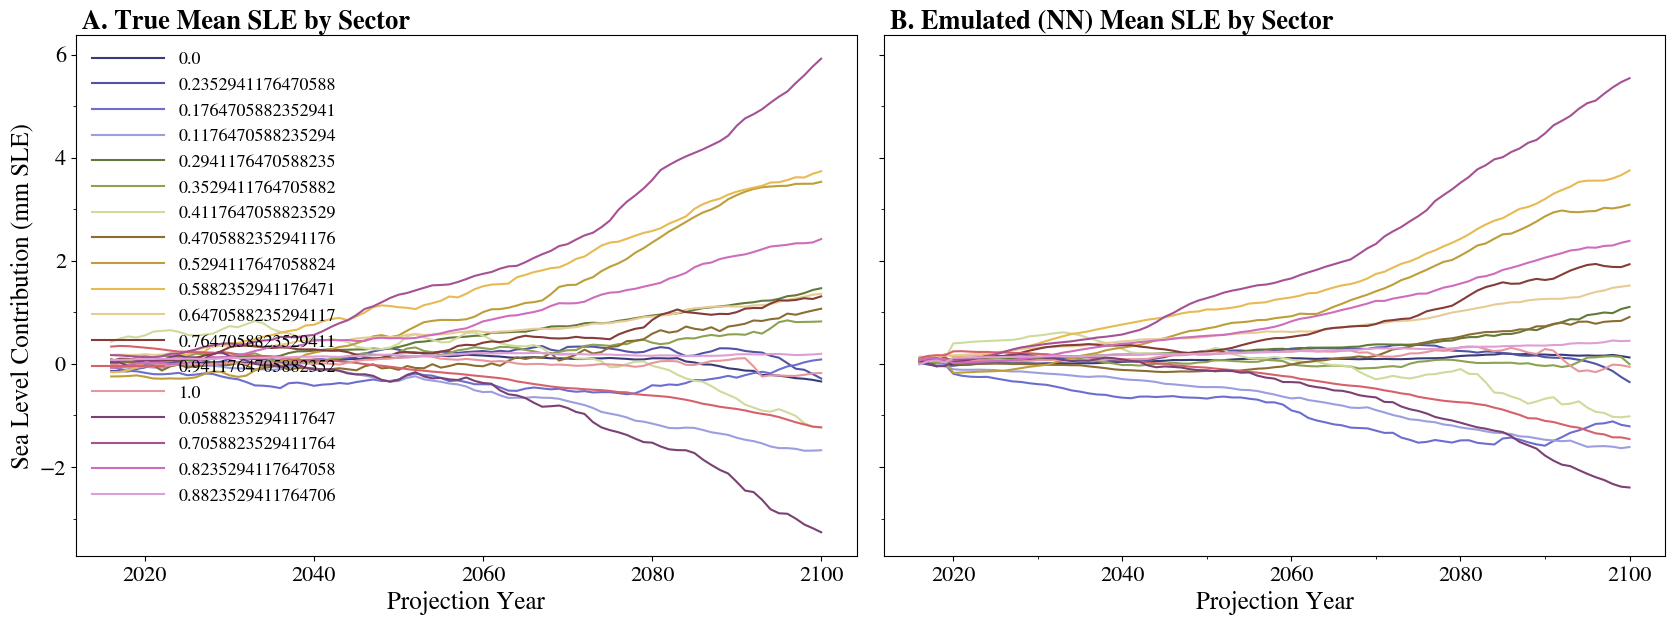

In [26]:
colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, 18))
ax.set_prop_cycle('color', colors)

fig, axs = plt.subplots(1, 2, figsize=(17, 6.5), sharey=True, sharex=False)

true = pd.DataFrame(dataset.groupby(by=['year', 'sectors']).mean()['true']).reset_index()

number_of_plots=18
colormap = plt.cm.tab20b #I suggest to use nipy_spectral, Set1,Paired
axs[0].set_prop_cycle('color', [colormap(i) for i in np.linspace(0, 1,number_of_plots)])
axs[1].set_prop_cycle('color', [colormap(i) for i in np.linspace(0, 1,number_of_plots)])


for i in set(true.sectors):
    p = true[true.sectors == i]
    axs[0].plot(np.arange(2016, 2101,), p.true, label=str(i))

pred = pd.DataFrame(dataset.groupby(by=['year', 'sectors']).mean()['pred']).reset_index()

for i in set(pred.sectors):
    p = pred[pred.sectors == i]
    axs[1].plot(np.arange(2016, 2101,), p.pred)

axs[0].set_ylabel('Sea Level Contribution (mm SLE)', {'fontsize': 18})
axs[1].yaxis.set_major_formatter(ScalarFormatter())
axs[1].yaxis.set_minor_locator(  AutoMinorLocator(2))
axs[1].xaxis.set_minor_locator(  AutoMinorLocator(2))

axs[0].text(2012.5, 6.5, 'A. True Mean SLE by Sector', {'fontsize': 19, 'weight': 550})
axs[1].text(2012.5, 6.5, 'B. Emulated (NN) Mean SLE by Sector', {'fontsize': 19, 'weight': 550})

# axs[1].set_xlabel("Sea Level Contribution (mm SLE)", {'fontsize': 18})
axs[0].set_xlabel("Projection Year", {'fontsize': 18})
axs[1].set_xlabel("Projection Year", {'fontsize': 18})
# axs[1].set_ylabel("Density", {'fontsize': 18})
# axs[1].set_ylabel("Density", {'fontsize': 18})
# axs[1].legend(frameon=False, loc='upper left',ncol=1,handlelength=4)
axs[0].legend(frameon=False, loc='upper left',ncol=1,handlelength=4)
# axs[1].set_xlim([-20, 16])

if save_figures:
    plt.savefig('mean_by_sector.svg',)

plt.show()